# Sparse Sensor Placement Optimization for Classification (SSPOC)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn import metrics

import pysensors as ps

## Binary classification (LDA)

In [2]:
digits = datasets.load_digits(n_class=2)
X = digits.data
y = digits.target

n_samples, n_features = X.shape
print(n_samples, n_features)

360 64


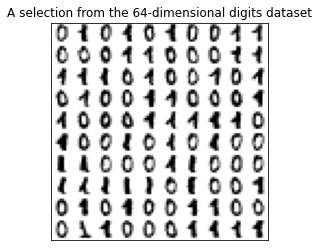

In [3]:
# Plot some digits
n_img_per_row = 10
img = np.zeros((10 * n_img_per_row, 10 * n_img_per_row))
for i in range(n_img_per_row):
    ix = 10 * i + 1
    for j in range(n_img_per_row):
        iy = 10 * j + 1
        img[ix:ix + 8, iy:iy + 8] = X[i * n_img_per_row + j].reshape((8, 8))

plt.imshow(img, cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.title('A selection from the 64-dimensional digits dataset')
plt.show()

In [4]:
model = ps.SSPOC(threshold=2)
model.fit(X, y);

/home/brian/Documents/Dropbox (uwamath)/Brian/Research/PySensors/pySensors/venv/lib/python3.6/site-packages/sklearn/linear_model/_omp.py:390: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)


In [5]:
print('Portion of sensors used:', len(model.selected_sensors) / 64)
print('Selected sensors:', model.selected_sensors)

Portion of sensors used: 0.09375
Selected sensors: [ 6 14 16 24 28 57]


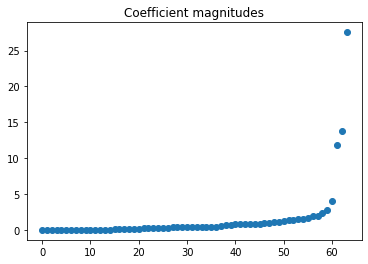

In [6]:
plt.plot(np.sort(np.abs(model.sensor_coef_)), 'o')
plt.title('Coefficient magnitudes');

In [7]:
y_pred = model.predict(X[:, model.selected_sensors])
print('Incorrect classifications:', sum(np.abs(y - y_pred)), 'out of', len(y))
print('Accuracy:', metrics.accuracy_score(y, y_pred))

Incorrect classifications: 12 out of 360
Accuracy: 0.9666666666666667


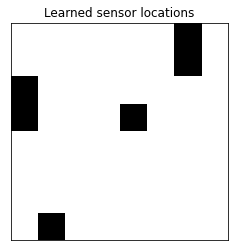

In [8]:
# Plot sensor locations
img = np.zeros(64)
img[model.selected_sensors] = 16

plt.imshow(img.reshape(8, 8), cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.title('Learned sensor locations')
plt.show()

## Multiclass classification (LDA)

In [2]:
digits = datasets.load_digits(n_class=10)
X = digits.data
y = digits.target

n_samples, n_features = X.shape
print(n_samples, n_features)

1797 64


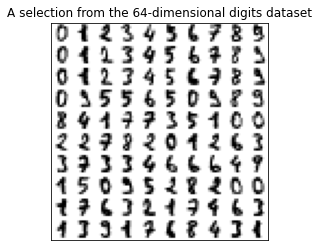

In [3]:
# Plot some digits
n_img_per_row = 10
img = np.zeros((10 * n_img_per_row, 10 * n_img_per_row))
for i in range(n_img_per_row):
    ix = 10 * i + 1
    for j in range(n_img_per_row):
        iy = 10 * j + 1
        img[ix:ix + 8, iy:iy + 8] = X[i * n_img_per_row + j].reshape((8, 8))

plt.imshow(img, cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.title('A selection from the 64-dimensional digits dataset')
plt.show()

In [4]:
threshold = 0.1
l1_penalty = 0.01
model = ps.SSPOC(threshold=threshold, l1_penalty=l1_penalty)
model.fit(X, y)

print('Portion of sensors used:', len(model.selected_sensors) / 64)
print('Selected sensors:', model.selected_sensors)

Portion of sensors used: 0.546875
Selected sensors: [ 1  3  5  6  7  8 10 12 15 16 20 21 22 23 24 30 31 33 38 40 41 42 43 44
 46 47 48 49 52 53 55 56 57 62 63]


In [5]:
# Check accuracy on training set
y_pred = model.predict(X[:, model.selected_sensors])
print('Accuracy:', metrics.accuracy_score(y, y_pred))

Accuracy: 0.9204229271007234


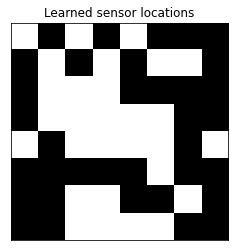

In [6]:
# Plot sensor locations
img = np.zeros(64)
img[model.selected_sensors] = 16

plt.imshow(img.reshape(8, 8), cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.title('Learned sensor locations')
plt.show()

Classification report for classifier SSPOC(basis=Identity(n_basis_modes=1797),
      classifier=LinearDiscriminantAnalysis(), l1_penalty=0.01, n_sensors=35,
      threshold=0.1):
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       178
           1       0.86      0.88      0.87       182
           2       0.92      0.89      0.91       177
           3       0.87      0.90      0.88       183
           4       0.96      0.96      0.96       181
           5       0.99      0.95      0.97       182
           6       0.99      0.98      0.99       181
           7       0.95      0.93      0.94       179
           8       0.80      0.85      0.83       174
           9       0.88      0.88      0.88       180

    accuracy                           0.92      1797
   macro avg       0.92      0.92      0.92      1797
weighted avg       0.92      0.92      0.92      1797




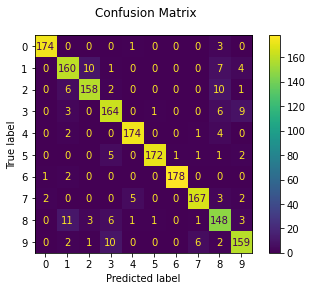

In [7]:
print("Classification report for classifier %s:\n%s\n"
      % (model, metrics.classification_report(y, y_pred)))
disp = metrics.plot_confusion_matrix(model.classifier, X[:, model.selected_sensors], y)
disp.figure_.suptitle("Confusion Matrix")

plt.show()

### Choosing sensors
For multiclass problems the "importance coefficients" form a matrix, with each row corresponding to a pixel and each column to a class. In order to select important sensors (pixels/rows), a function is applied row-wise to aggregate coefficients into a sigle score for each sensor, forming a vector of scores. These scores are then used to choose which sensors to retain. Note that if `l1_penalty` was set too high, then the importance coefficients matrix may not have any nonzero entries, making it impossible to prioritize which sensors to select.

Below we give examples of some possible aggregating functions.

/home/brian/Documents/Dropbox (uwamath)/Brian/Research/PySensors/pySensors/venv/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


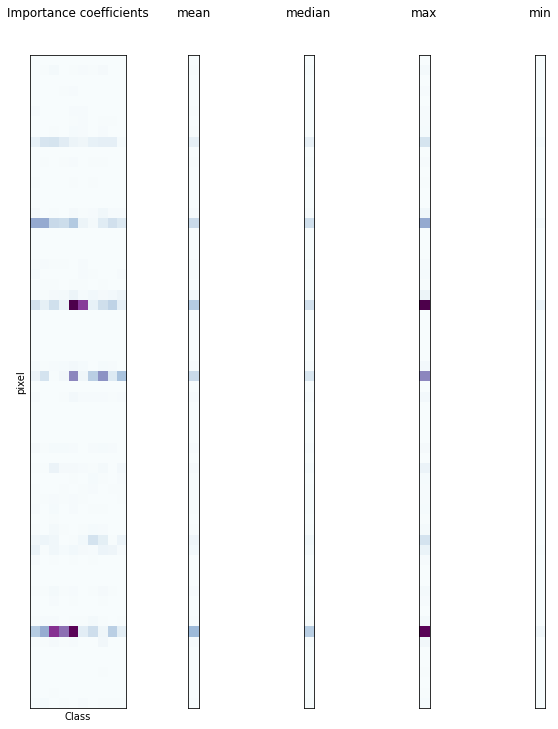

In [8]:
methods = [
    ('mean', np.mean),
    ('median', np.median),
    ('max', np.max),
    ('min', np.min)
]

# Normalize the colormaps
coef_magnitudes = np.abs(model.sensor_coef_)
vmin = np.min(coef_magnitudes)
vmax = np.max(coef_magnitudes)

plot_kws = dict(vmin=vmin, vmax=vmax, cmap="BuPu")

fig, axs = plt.subplots(1, len(methods) + 1, sharey=True, figsize=(10, 12))

axs[0].matshow(coef_magnitudes, aspect="auto", **plot_kws)
axs[0].set(xlabel="Class", ylabel="pixel", title="Importance coefficients", xticks=[], yticks=[])

for k, (name, method) in enumerate(methods, 1):
    axs[k].matshow(method(coef_magnitudes, axis=1).reshape(-1, 1), **plot_kws)
    axs[k].set(title=name, xticks=[], yticks=[])

fig.show()

Once we have this score vector, there are a two ways we might use it to select sensors:
1. Take the sensors corresponding to the **top-k** scores
2. Take *all* sensors with scores exceeding some **threshold**

We explore both options below.

#### Top-k sensors
Here we measure how the performance of the classifier changes as we directly vary the number of sensors for four different choices of aggregating methods.

/home/brian/Documents/Dropbox (uwamath)/Brian/Research/PySensors/pySensors/pysensors/sspoc.py:223: UserWarning: SSPOC model has no selected sensors so predictions are random. Increase n_sensors or lower threshold with SSPOC.update_sensors.
  "SSPOC model has no selected sensors so predictions are random. "
/home/brian/Documents/Dropbox (uwamath)/Brian/Research/PySensors/pySensors/pysensors/sspoc.py:223: UserWarning: SSPOC model has no selected sensors so predictions are random. Increase n_sensors or lower threshold with SSPOC.update_sensors.
  "SSPOC model has no selected sensors so predictions are random. "
/home/brian/Documents/Dropbox (uwamath)/Brian/Research/PySensors/pySensors/pysensors/sspoc.py:223: UserWarning: SSPOC model has no selected sensors so predictions are random. Increase n_sensors or lower threshold with SSPOC.update_sensors.
  "SSPOC model has no selected sensors so predictions are random. "
/home/brian/Documents/Dropbox (uwamath)/Brian/Research/PySensors/pySensors/p

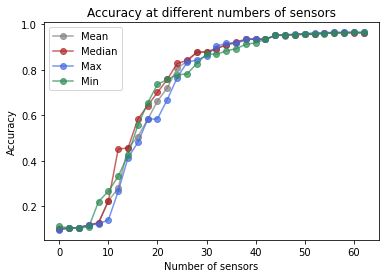

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
plot_kws = dict(alpha=0.7, marker="o", linestyle=None)

methods = (np.mean, np.median, np.max, np.min)
names = ('Mean', 'Median', 'Max', 'Min')
colors = ('gray', 'firebrick', 'royalblue', 'seagreen')

accuracy = {name: [] for name in names}
n_sensors_array = np.arange(0, 64, 2)

for n_sensors in n_sensors_array:
    for method, name in zip(methods, names):
        model.update_sensors(n_sensors=n_sensors, xy=(X, y), method=method, quiet=True)
        if model.n_sensors > 0:
            y_pred = model.predict(X[:, model.selected_sensors])
        else:
            y_pred = model.predict(X)
        accuracy[name].append(metrics.accuracy_score(y, y_pred))
        

for name, color in zip(names, colors):
    ax.plot(n_sensors_array, accuracy[name], color=color, label=name, **plot_kws)
    

ax.set(xlabel='Number of sensors', ylabel='Accuracy', title='Accuracy at different numbers of sensors')
ax.legend()

fig.show()

#### Thresholding
Another way to obtain different numbers of sensors is by applying a thresholding rule. We simply specify a threshold and use all sensors whose score exceeds it. Note that this entails that we won't be able to directly control the number of sensors that is chosen.

Let's see how the accuracy and number of sensors varies as we change the threshold.

/home/brian/Documents/Dropbox (uwamath)/Brian/Research/PySensors/pySensors/pysensors/sspoc.py:223: UserWarning: SSPOC model has no selected sensors so predictions are random. Increase n_sensors or lower threshold with SSPOC.update_sensors.
  "SSPOC model has no selected sensors so predictions are random. "
/home/brian/Documents/Dropbox (uwamath)/Brian/Research/PySensors/pySensors/pysensors/sspoc.py:223: UserWarning: SSPOC model has no selected sensors so predictions are random. Increase n_sensors or lower threshold with SSPOC.update_sensors.
  "SSPOC model has no selected sensors so predictions are random. "
/home/brian/Documents/Dropbox (uwamath)/Brian/Research/PySensors/pySensors/pysensors/sspoc.py:223: UserWarning: SSPOC model has no selected sensors so predictions are random. Increase n_sensors or lower threshold with SSPOC.update_sensors.
  "SSPOC model has no selected sensors so predictions are random. "
/home/brian/Documents/Dropbox (uwamath)/Brian/Research/PySensors/pySensors/p

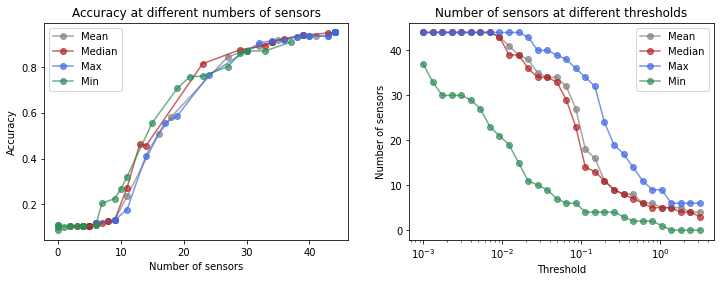

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

n_sensors = {name: [] for name in names}
accuracy = {name: [] for name in names}
thresholds = np.logspace(-3, 0.5, 30)

for thresh in thresholds:
    for method, name in zip(methods, names):
        model.update_sensors(threshold=thresh, xy=(X, y), method=method, quiet=True)
        if model.n_sensors > 0:
            y_pred = model.predict(X[:, model.selected_sensors])
        else:
            y_pred = model.predict(X)
        accuracy[name].append(metrics.accuracy_score(y, y_pred))
        n_sensors[name].append(len(model.selected_sensors))
        

for name, color in zip(names, colors):
    axs[0].plot(n_sensors[name], accuracy[name], color=color, label=name, **plot_kws)
    axs[1].plot(thresholds, n_sensors[name], color=color, label=name, **plot_kws)
    

axs[0].set(xlabel='Number of sensors', ylabel='Accuracy', title='Accuracy at different numbers of sensors')
axs[1].set(xlabel='Threshold', xscale='log', ylabel='Number of sensors', title='Number of sensors at different thresholds')
axs[0].legend()
axs[1].legend()

fig.show()

When the threshold is set high enough that no sensors are selected, the model will resort to predicting labels at random.

### Varying the L1 penalty
Another way to obtain different sets of sensors is to change the L1 regularization strength, `l1_penalty`, that's used when finding the coefficient matrix. This tweaks the underlying optimization problem, which can result in different slightly different sets of sensors being prioritized.

Let's see what the coefficient matrices look like for a few different choices of `l1_penalty`

/home/brian/Documents/Dropbox (uwamath)/Brian/Research/PySensors/pySensors/venv/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:1914: UserWarning: Coordinate descent with l1_reg=0 may lead to unexpected results and is discouraged.
  check_random_state(self.random_state), random)


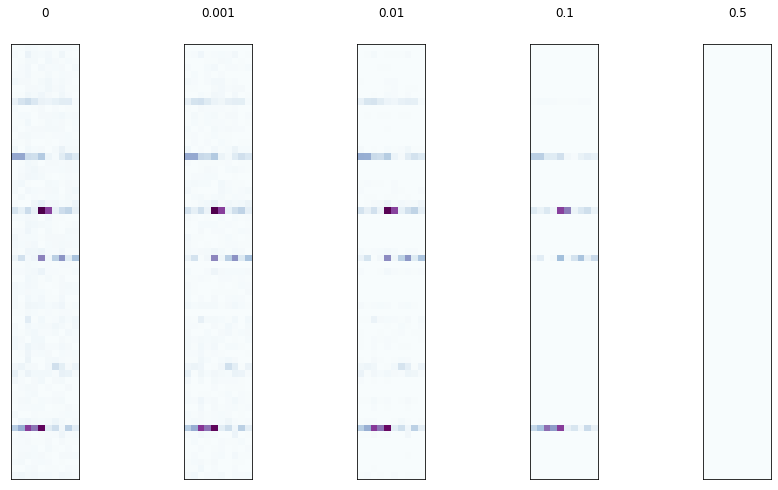

In [20]:
l1_penalties = [0, 0.001, 0.01, 0.1, 0.5]
fig, axs = plt.subplots(1, len(l1_penalties), figsize=(15, 8))

coefficient_matrices = [
    np.abs(
        ps.SSPOC(l1_penalty=l1_penalty).fit(X, y, refit=False).sensor_coef_
    ) for l1_penalty in l1_penalties
]

vmax = max(np.max(s) for s in coefficient_matrices)
vmin = max(np.min(s) for s in coefficient_matrices)
plot_kws = dict(vmin=vmin, vmax=vmax, cmap="BuPu")

for l1_penalty, s, ax in zip(l1_penalties, coefficient_matrices, axs):
    ax.matshow(s, **plot_kws)
    ax.set(title=str(l1_penalty), xticks=[], yticks=[])

The dominant rows seem to be consistent, but there is some minor variation in the other rows.

Next we look at how the accuracy of the classifier changes as a function of the `l1_penalty` parameter. We also see how the number of selected sensors changes when we fix a threshold and vary `l1_penalty`.

/home/brian/Documents/Dropbox (uwamath)/Brian/Research/PySensors/pySensors/venv/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:1914: UserWarning: Coordinate descent with l1_reg=0 may lead to unexpected results and is discouraged.
  check_random_state(self.random_state), random)
/home/brian/Documents/Dropbox (uwamath)/Brian/Research/PySensors/pySensors/pysensors/sspoc.py:335: UserWarning: Threshold set too high (0.1); no sensors selected.
  f"Threshold set too high ({threshold}); no sensors selected."
/home/brian/Documents/Dropbox (uwamath)/Brian/Research/PySensors/pySensors/pysensors/sspoc.py:345: UserWarning: No selected sensors; model was not refit.
  warnings.warn("No selected sensors; model was not refit.")
/home/brian/Documents/Dropbox (uwamath)/Brian/Research/PySensors/pySensors/pysensors/sspoc.py:223: UserWarning: SSPOC model has no selected sensors so predictions are random. Increase n_sensors or lower threshold with SSPOC.update_sensors.
  "SSPOC model

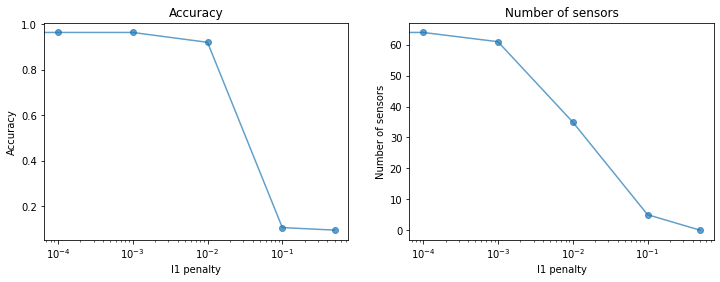

In [23]:
threshold = 0.1
l1_penalties = [0, 0.0001, 0.001, 0.01, 0.1, 0.5]

accuracy = []
n_sensors = []

for l1_penalty in l1_penalties:
    model = ps.SSPOC(threshold=threshold, l1_penalty=l1_penalty).fit(X, y)
    if model.n_sensors > 0:
        y_pred = model.predict(X[:, model.selected_sensors])
    else:
        y_pred = model.predict(X)
    accuracy.append(metrics.accuracy_score(y, y_pred))
    n_sensors.append(model.n_sensors)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
plot_kws = dict(alpha=0.7, marker="o")
axs[0].plot(l1_penalties, accuracy, **plot_kws)
axs[0].set(xlabel="l1 penalty", ylabel="Accuracy", title="Accuracy", xscale="log")
axs[1].plot(l1_penalties, n_sensors, **plot_kws)
axs[1].set(xlabel="l1 penalty", ylabel="Number of sensors", title="Number of sensors", xscale="log");

## Other classifiers
`SSPOC` is compatible with other classifiers, namely *linear* classifiers. Any linear classifier implementing `fit` and `predict` methods and having a `coef_` attribute can be passed to a `SSPOC` instance.

Let's compare the performance of a few of Scikit-learn's popular linear classifiers.

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier

In [41]:
classifiers = [
    ('Ridge', RidgeClassifier(alpha=0.01)),
    ('Perceptron', Perceptron(penalty='elasticnet', alpha=0.1)),
    ('Logistic regression', LogisticRegression(C=10, max_iter=500, tol=1e-3)),
    ('SGD', SGDClassifier(max_iter=5000)),
]

for classifier in classifiers:
    print('----------------------------------------------------')
    print(classifier[0])
    print('----------------------------------------------------')
    
    model = ps.SSPOC(classifier=classifier[1], threshold=threshold, l1_penalty=l1_penalty)
    model.fit(X, y)

    print('Portion of sensors used:', len(model.selected_sensors) / 64)
    print('Selected sensors:', model.selected_sensors)

    # Check accuracy on training set
    y_pred = model.predict(X[:, model.selected_sensors])
    print('Accuracy:', metrics.accuracy_score(y, y_pred), '\n\n')

----------------------------------------------------
Ridge
----------------------------------------------------
Portion of sensors used: 0.03125
Selected sensors: [24 56]
Accuracy: 0.10294936004451864 


----------------------------------------------------
Perceptron
----------------------------------------------------
Portion of sensors used: 0.765625
Selected sensors: [ 1  2  3  4  5  6  9 10 11 12 13 14 17 18 19 20 21 22 25 26 27 28 29 30
 33 34 35 36 37 38 41 42 43 44 45 46 49 50 51 52 53 54 55 58 59 60 61 62
 63]
Accuracy: 0.18586533110740122 


----------------------------------------------------
Logistic regression
----------------------------------------------------


/home/brian/Documents/Dropbox (uwamath)/Brian/Research/PySensors/pySensors/venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/brian/Documents/Dropbox (uwamath)/Brian/Research/PySensors/pySensors/venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also ref

Portion of sensors used: 0.28125
Selected sensors: [ 4  5 12 19 20 21 26 27 28 30 38 42 43 44 46 53 54 58]
Accuracy: 0.9794101279910963 


----------------------------------------------------
SGD
----------------------------------------------------
Portion of sensors used: 1.0
Selected sensors: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
Accuracy: 0.9732888146911519 




Though logistic regression fails to fully converge, it appears to make the most efficient use of sensors.

## Other bases
In all the experiments thus far we've worked with the raw examples. What happens if we represent the images in different bases?

We'll fix the number of basis modes at 32 and vary the number of sensors the models are allowed to use, then measure accuracy.
TODO

In [19]:
n_basis_modes = 32
bases = [
    ('Identity', ps.basis.Identity(n_basis_modes=n_basis_modes)),
    ('POD', ps.basis.POD(n_basis_modes=n_basis_modes)),
    ('Random projection', ps.basis.RandomProjection(n_basis_modes=n_basis_modes)),    
]

for basis in bases:
    print('----------------------------------------------------')
    print(basis[0])
    print('----------------------------------------------------')
    
    model = ps.SSPOC(basis=basis[1], threshold=threshold, l1_penalty=l1_penalty)
    model.fit(X, y)

    print('Portion of sensors used:', len(model.selected_sensors) / 64)
    print('Selected sensors:', model.selected_sensors)

    # Check accuracy on training set
    y_pred = model.predict(X[:, model.selected_sensors])
    print('Accuracy:', metrics.accuracy_score(y, y_pred), '\n\n')

----------------------------------------------------
Identity
----------------------------------------------------
Portion of sensors used: 0.328125
Selected sensors: [ 1  7  8 15 16 21 23 24 30 31 33 38 40 46 47 48 52 55 56 57 63]
Accuracy: 0.6649972175848636 


----------------------------------------------------
POD
----------------------------------------------------
Portion of sensors used: 0.203125
Selected sensors: [ 5 12 20 21 26 30 33 36 38 43 44 52 53]
Accuracy: 0.8469671675013912 


----------------------------------------------------
Random projection
----------------------------------------------------


/home/brian/Documents/Dropbox (uwamath)/Brian/Research/PySensors/pySensors/pysensors/basis/_identity.py:71: UserWarning: Only the first 32 examples were retained.
  warn(f"Only the first {self.n_basis_modes} examples were retained.")


Portion of sensors used: 0.640625
Selected sensors: [ 2  5  6 10 12 13 14 17 18 19 20 21 22 25 26 27 28 29 30 33 35 36 37 38
 41 42 43 44 45 46 49 50 51 52 53 54 58 60 61 62 63]
Accuracy: 0.9593767390094602 




For this classification task, the `POD` basis gives the best results using the fewest sensors. 